In [443]:
import os
path = '/Users/yichingchan/Documents/FunNow_商業數據分析題目/retetion_log'
os.chdir(path)

In [515]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#import matplotlib as mpl
%matplotlib inline
#sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', 500)
from datetime import datetime

#import warnings
#warnings.filterwarnings('ignore')

In [445]:
#2018年1到6月註冊帳號的使用者及他們註冊的時間
regist = pd.read_csv(path + '/registration_log.csv')
df_regist = regist.copy()

In [446]:
#2018年1到9月使用者打開 app 的時間紀錄
app = pd.read_csv(path + '/app_open_log.csv')
df_app = app.copy()

In [447]:
#2018年1到7月使用者的訂單資訊
purchase = pd.read_csv(path + '/purchase_log.csv')
df_purchase = purchase.copy()

In [448]:
#先convert date col to datetime dtype
df_regist['signup_time'] = pd.to_datetime(df_regist['signup_time'])
df_app['app_open_time'] = pd.to_datetime(df_app['app_open_time'])
df_purchase['purchase_time'] = pd.to_datetime(df_purchase['purchase_time'])

In [449]:
#check if any null values --> nope!
print(df_regist.isnull().values.any())
print(df_app.isnull().values.any())
print(df_purchase.isnull().values.any())

False
False
False


In [450]:
print(df_regist.shape[0] == df_regist['user_id'].nunique()) #確認註冊表單使用者unique
print(df_app.shape[0] == df_app['user_id'].nunique()) 
print(df_purchase.shape[0] == df_purchase['user_id'].nunique())

True
False
False


## Part 1: 依使用者註冊月份的月留存率 (monthly retention) 圖
留存定義:當月有開啟 app 即算當月留存

In [451]:
#define user's cohort group based upon when they sign up
df_regist['JoinPeriod'] = df_regist['signup_time'].apply(lambda x: x.strftime('%Y-%m'))
df_regist.head()

,user_id,signup_time,JoinPeriod
0,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:17,2018-01
1,8ff943305e147405b2f188a9ce52343d,2018-01-01 01:54:53,2018-01
2,a488b0d03a56cf7f45b93981209a5a42,2018-01-01 02:00:43,2018-01
3,450f15f6910c722cefd0b7aa17389181,2018-01-01 02:19:12,2018-01
4,d2e5f02028da9445537913c73cdc5f4c,2018-01-01 02:37:45,2018-01


In [452]:
#add AppOpenPeriod col to make timestramp easier to read
df_app['AppOpenPeriod'] = df_app['app_open_time'].apply(lambda x: x.strftime('%Y-%m'))
df_app.head()

,user_id,app_open_time,AppOpenPeriod
0,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:18,2018-01
1,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:18,2018-01
2,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:19,2018-01
3,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:31,2018-01
4,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:34,2018-01


In [453]:
#檢查開啟app的是否都是已註冊會員 --> 是！
id_signup_lst = list(df_regist['user_id'])
print(df_app['user_id'].isin(id_signup_lst).value_counts())
print()
#有註冊會員的都會開啟app嗎？ --> 沒有！
id_open_lst = list(df_app['user_id'].unique())
print(df_regist['user_id'].isin(id_open_lst).value_counts())

True    603115
Name: user_id, dtype: int64

True     6292
False      75
Name: user_id, dtype: int64


In [454]:
#檢查註冊時間是否一定等於開啟app時間 -> No! (94 contains 75 of those who never open app)
FirstOpen = pd.DataFrame(df_app.groupby('user_id')['app_open_time'].min().apply(lambda x: x.strftime('%Y-%m')))
temp = pd.merge(FirstOpen, df_regist, on='user_id', how='outer')
temp['join&open'] = temp['app_open_time'] == temp['JoinPeriod']
temp['join&open'].value_counts()

True     6273
False      94
Name: join&open, dtype: int64

In [455]:
print(temp[temp['join&open']==False]['user_id'].nunique()) #註冊時間!=開啟app時間 + 有註冊但沒開啟過app
print(temp['app_open_time'].isnull().value_counts()) #有註冊但沒開過app

94
False    6292
True       75
Name: app_open_time, dtype: int64


In [456]:
#merge AppOpen and SignUp tables (full join)
df_merge = pd.merge(df_app[['user_id', 'AppOpenPeriod']], df_regist[['user_id', 'JoinPeriod']], on = 'user_id', how = 'outer')
df_merge.head()

,user_id,AppOpenPeriod,JoinPeriod
0,c2e117bb5f8d9107525ad234b7195eba,2018-01,2018-01
1,c2e117bb5f8d9107525ad234b7195eba,2018-01,2018-01
2,c2e117bb5f8d9107525ad234b7195eba,2018-01,2018-01
3,c2e117bb5f8d9107525ad234b7195eba,2018-01,2018-01
4,c2e117bb5f8d9107525ad234b7195eba,2018-01,2018-01


In [457]:
df_merge.isnull().values.any() #因為有人有註冊但沒open app

True

In [458]:
#count the unique users per group and period
cohorts = df_merge.groupby(['JoinPeriod', 'AppOpenPeriod']).agg({'user_id': pd.Series.nunique}) #沒打開app從這一步開始就不會被計入
cohorts.rename(columns={'user_id': 'TotalUsers'}, inplace=True)
cohorts.head()

TotalUsers
JoinPeriod AppOpenPeriod            
2018-01    2018-01               712
           2018-02               296
           2018-03               201
           2018-04               168
           2018-05               160

In [459]:
#get cohort period so that we can compare among groups
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  CohortPeriod
JoinPeriod AppOpenPeriod                          
2018-01    2018-01               712             1
           2018-02               296             2
           2018-03               201             3
           2018-04               168             4
           2018-05               160             5

In [460]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinPeriod', 'CohortPeriod'], inplace=True)

In [461]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = df_regist.groupby('JoinPeriod').count()['user_id']#每月新註冊人數
cohort_group_size

JoinPeriod
2018-01     724
2018-02     888
2018-03    1359
2018-04    1270
2018-05    1135
2018-06     991
Name: user_id, dtype: int64

In [462]:
#get absolute numbers 
user_retention = cohorts['TotalUsers'].unstack(0)
user_retention

JoinPeriod,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
CohortPeriod,,,,,,
1,712.0,882.0,1329.0,1254.0,1119.0,977.0
2,296.0,323.0,529.0,492.0,430.0,430.0
3,201.0,228.0,398.0,320.0,345.0,301.0
4,168.0,196.0,267.0,315.0,258.0,222.0
5,160.0,159.0,263.0,264.0,220.0,NaN
6,135.0,161.0,208.0,199.0,NaN,NaN
7,119.0,152.0,188.0,NaN,NaN,NaN
8,106.0,120.0,NaN,NaN,NaN,NaN
9,100.0,NaN,NaN,NaN,NaN,NaN


In [463]:
#check if 'number of new joins' is equivalent to 'number of open app' in each JoinPeriod
num_join = user_retention.loc[1]
num_check = pd.concat([num_join.astype(int), cohort_group_size], axis=1)
num_check.columns = ['numOpenApp', 'numJoin']
num_check['equivalent'] = num_check['numJoin'] == num_check['numOpenApp']
num_check

,numOpenApp,numJoin,equivalent
JoinPeriod,,,
2018-01,712,724,False
2018-02,882,888,False
2018-03,1329,1359,False
2018-04,1254,1270,False
2018-05,1119,1135,False
2018-06,977,991,False


In [464]:
#get retention RATE
user_retention = user_retention.divide(cohort_group_size, axis=1).T
user_retention

CohortPeriod,1,2,3,4,5,6,7,8,9
JoinPeriod,,,,,,,,,
2018-01,0.983425,0.408840,0.277624,0.232044,0.220994,0.186464,0.164365,0.146409,0.138122
2018-02,0.993243,0.363739,0.256757,0.220721,0.179054,0.181306,0.171171,0.135135,NaN
2018-03,0.977925,0.389257,0.292862,0.196468,0.193525,0.153054,0.138337,NaN,NaN
2018-04,0.987402,0.387402,0.251969,0.248031,0.207874,0.156693,NaN,NaN,NaN
2018-05,0.985903,0.378855,0.303965,0.227313,0.193833,NaN,NaN,NaN,NaN
2018-06,0.985873,0.433905,0.303734,0.224016,NaN,NaN,NaN,NaN,NaN


In [465]:
#加入每月新註冊人數
user_retention.insert(0,'New Users', cohort_group_size)
user_retention

CohortPeriod,New Users,1,2,3,4,5,6,7,8,9
JoinPeriod,,,,,,,,,,
2018-01,724,0.983425,0.408840,0.277624,0.232044,0.220994,0.186464,0.164365,0.146409,0.138122
2018-02,888,0.993243,0.363739,0.256757,0.220721,0.179054,0.181306,0.171171,0.135135,NaN
2018-03,1359,0.977925,0.389257,0.292862,0.196468,0.193525,0.153054,0.138337,NaN,NaN
2018-04,1270,0.987402,0.387402,0.251969,0.248031,0.207874,0.156693,NaN,NaN,NaN
2018-05,1135,0.985903,0.378855,0.303965,0.227313,0.193833,NaN,NaN,NaN,NaN
2018-06,991,0.985873,0.433905,0.303734,0.224016,NaN,NaN,NaN,NaN,NaN


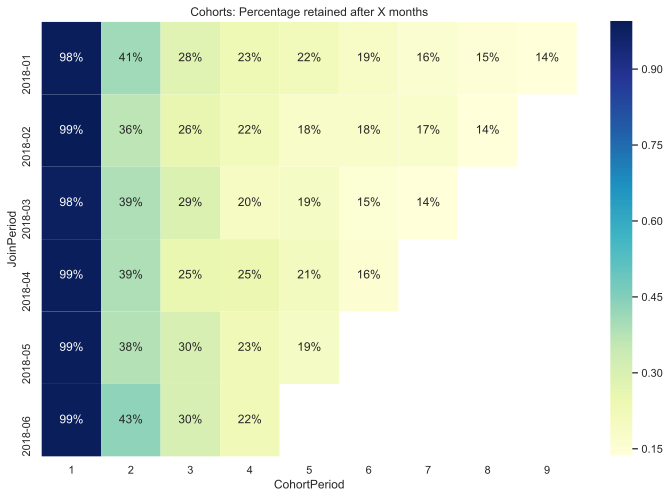

In [522]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Percentage retained after X months')
sns.heatmap(user_retention.iloc[:,1:], mask=user_retention.iloc[:,1:].isnull(), annot=True, fmt='.0%', cmap="YlGnBu", );
plt.savefig('all.png', dpi=300)

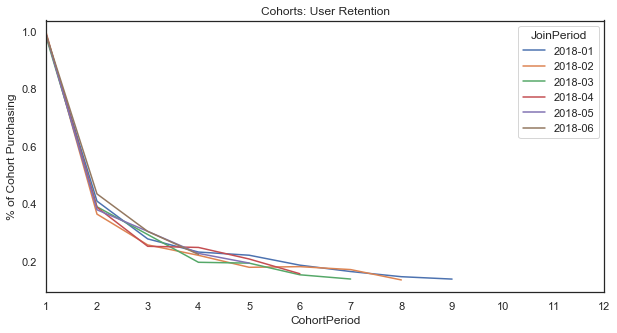

In [468]:
user_retention.iloc[:,1:].T[['2018-01', '2018-02', '2018-03','2018-04','2018-05','2018-06']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

## Part2: cohort analysis with subgroups
(1)註冊後一個月內有消費 (2) 註冊後一個月內沒有消費

In [469]:
df_purchase.head()

,user_id,purchase_time
0,3b2825eb1b54022b2b1b9172c00bcfda,2018-01-01 21:37:52
1,1d6b38758ce29c175ebde724a5b8e0f9,2018-01-02 09:33:27
2,110a49fae39f8bf4ee9ee2d40ebc5600,2018-01-02 13:07:12
3,ec4d8996fcbaad62ec1370b5140e3bdb,2018-01-02 18:34:07
4,2eb4ecb635ae8517ea29178c75aa2c0e,2018-01-02 20:10:03


In [470]:
#先檢查有消費的是否都已註冊會員 --> 是！
id_signup_lst = list(df_regist['user_id'])
print(df_purchase['user_id'].isin(id_signup_lst).value_counts())
print()
#有註冊會員的都有消費嗎？ --> 沒有！
id_purchase_lst = list(df_purchase['user_id'].unique())
print(df_regist['user_id'].isin(id_purchase_lst).value_counts())

True    2058
Name: user_id, dtype: int64

False    5438
True      929
Name: user_id, dtype: int64


In [471]:
#找出每個user最早一次消費時間
first_purchase = pd.DataFrame(df_purchase.groupby('user_id')['purchase_time'].min().reset_index())

In [472]:
#合併註冊table和首購table
regi_buy = pd.merge(df_regist, first_purchase, on=['user_id'], how='left')
regi_buy.head()

,user_id,signup_time,JoinPeriod,purchase_time
0,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:17,2018-01,NaT
1,8ff943305e147405b2f188a9ce52343d,2018-01-01 01:54:53,2018-01,NaT
2,a488b0d03a56cf7f45b93981209a5a42,2018-01-01 02:00:43,2018-01,NaT
3,450f15f6910c722cefd0b7aa17389181,2018-01-01 02:19:12,2018-01,NaT
4,d2e5f02028da9445537913c73cdc5f4c,2018-01-01 02:37:45,2018-01,NaT


In [473]:
#計算首購和註冊日期之差
regi_buy['time_diff'] = (regi_buy['purchase_time'] - regi_buy['signup_time'])/np.timedelta64(1, 'M')
regi_buy['time_diff'] = regi_buy['time_diff'].astype(float)
#標記「註冊後一個月內有消費」的為True，其餘為False（超過一個月才消費＋never消費的）
regi_buy.loc[regi_buy.time_diff <= 1 , 'BuyWithinOneMonth'] = True
regi_buy.loc[regi_buy.time_diff > 1 , 'BuyWithinOneMonth'] = False
regi_buy.loc[regi_buy.time_diff.isnull() , 'BuyWithinOneMonth'] = False

In [474]:
regi_buy.head()

,user_id,signup_time,JoinPeriod,purchase_time,time_diff,BuyWithinOneMonth
0,c2e117bb5f8d9107525ad234b7195eba,2018-01-01 01:12:17,2018-01,NaT,NaN,False
1,8ff943305e147405b2f188a9ce52343d,2018-01-01 01:54:53,2018-01,NaT,NaN,False
2,a488b0d03a56cf7f45b93981209a5a42,2018-01-01 02:00:43,2018-01,NaT,NaN,False
3,450f15f6910c722cefd0b7aa17389181,2018-01-01 02:19:12,2018-01,NaT,NaN,False
4,d2e5f02028da9445537913c73cdc5f4c,2018-01-01 02:37:45,2018-01,NaT,NaN,False


In [475]:
buyWithin = regi_buy[regi_buy['BuyWithinOneMonth'] == True]
NoWithin = regi_buy[regi_buy['BuyWithinOneMonth'] == False]

### (1) 註冊後一個月內有消費: 資料期間內共806人

In [476]:
num_within = regi_buy[regi_buy['BuyWithinOneMonth'] == True]['BuyWithinOneMonth'].count()
num_all = regi_buy.shape[0]
print('「註冊後一個月內有消費」人數:', num_within)
print('「註冊後一個月內有消費」佔全體會員比例:', round((num_within/num_all),2))

「註冊後一個月內有消費」人數: 806
「註冊後一個月內有消費」佔全體會員比例: 0.13


In [477]:
buyWithin.head()

,user_id,signup_time,JoinPeriod,purchase_time,time_diff,BuyWithinOneMonth
5,3b2825eb1b54022b2b1b9172c00bcfda,2018-01-01 05:22:17,2018-01,2018-01-01 21:37:52,0.022259,True
34,6735f4bec5e48bd5b6cdf79a3ad49831,2018-01-02 02:10:32,2018-01,2018-01-17 19:45:51,0.516901,True
36,c4047fd8cf53b4135d9371e70b12eeea,2018-01-02 06:20:36,2018-01,2018-01-02 21:49:01,0.021183,True
37,1d6b38758ce29c175ebde724a5b8e0f9,2018-01-02 07:09:35,2018-01,2018-01-02 09:33:27,0.003282,True
40,110a49fae39f8bf4ee9ee2d40ebc5600,2018-01-02 10:05:44,2018-01,2018-01-02 13:07:12,0.004140,True


In [478]:
def get_retention_rate(df_openapp, df_registration):
    #merge AppOpen and SignUp tables (full join)
    df_merge = pd.merge(df_openapp[['user_id', 'AppOpenPeriod']], df_registration[['user_id', 'JoinPeriod']], on = 'user_id', how = 'outer')
    print('anyone sign up but never open app?:', df_merge.isnull().values.any()) #因為有人有註冊但沒open app
    print()
    
    #count the unique users per group and period
    cohorts = df_merge.groupby(['JoinPeriod', 'AppOpenPeriod']).agg({'user_id': pd.Series.nunique}) #沒打開app從這一步開始就不會被計入
    cohorts.rename(columns={'user_id': 'TotalUsers'}, inplace=True)
    
    #get cohort period so that we can compare among groups
    def cohort_period(df):
        df['CohortPeriod'] = np.arange(len(df)) + 1
        return df
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    
    # reindex the DataFrame
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['JoinPeriod', 'CohortPeriod'], inplace=True)
    
    # create a Series holding the total size of each CohortGroup
    cohort_group_size = df_registration.groupby('JoinPeriod').count()['user_id']#每月新註冊人數
    
    #get retention number
    user_retention = cohorts['TotalUsers'].unstack(0)
    
    #check equivalence
    num_join = user_retention.loc[1]
    num_check = pd.concat([num_join.astype(int), cohort_group_size], axis=1)
    num_check.columns = ['numOpenApp', 'numJoin']
    num_check['equivalent'] = num_check['numJoin'] == num_check['numOpenApp']
    print(num_check)
    
    #get retention rate
    user_retention = user_retention.divide(cohort_group_size, axis=1).T
    
    #加入每月新註冊人數
    user_retention.insert(0,'New Users', cohort_group_size)
    
    return user_retention

In [479]:
buyWithin_retention = get_retention_rate(df_app,buyWithin)
buyWithin_retention

anyone sign up but never open app?: True

            numOpenApp  numJoin  equivalent
JoinPeriod                                 
2018-01            102      102        True
2018-02            113      113        True
2018-03            140      140        True
2018-04            157      157        True
2018-05            164      164        True
2018-06            130      130        True


CohortPeriod,New Users,1,2,3,4,5,6,7,8,9
JoinPeriod,,,,,,,,,,
2018-01,102,1.0,0.764706,0.578431,0.490196,0.460784,0.392157,0.372549,0.392157,0.372549
2018-02,113,1.0,0.681416,0.592920,0.486726,0.469027,0.415929,0.415929,0.380531,NaN
2018-03,140,1.0,0.742857,0.664286,0.578571,0.607143,0.421429,0.407143,NaN,NaN
2018-04,157,1.0,0.764331,0.554140,0.662420,0.509554,0.426752,NaN,NaN,NaN
2018-05,164,1.0,0.676829,0.689024,0.554878,0.481707,NaN,NaN,NaN,NaN
2018-06,130,1.0,0.776923,0.576923,0.523077,NaN,NaN,NaN,NaN,NaN


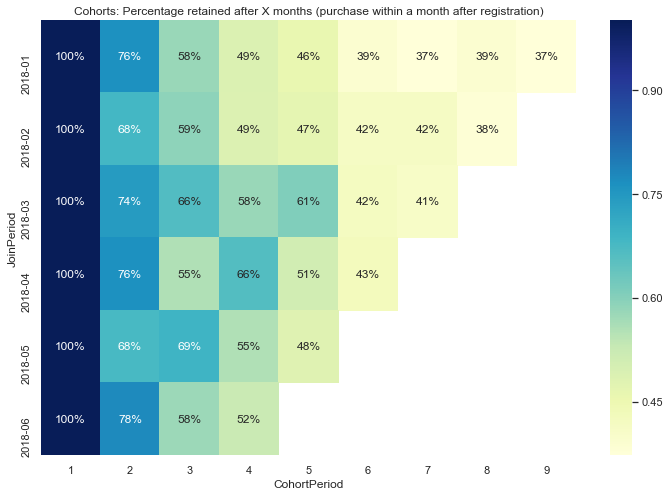

In [510]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Percentage retained after X months (purchase within a month after registration)')
sns.heatmap(buyWithin_retention.iloc[:,1:], mask=buyWithin_retention.iloc[:,1:].isnull(), annot=True, fmt='.0%', cmap="YlGnBu", );
plt.savefig('within.eps',format='eps')

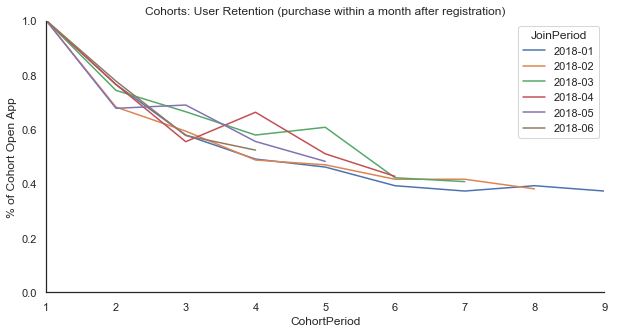

In [513]:
buyWithin_retention.iloc[:,1:].T[['2018-01', '2018-02', '2018-03','2018-04','2018-05','2018-06']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention (purchase within a month after registration)')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 9)
plt.ylim(0,1)
plt.ylabel('% of Cohort Open App')
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.savefig('折線圖條件有.eps',format='eps')

### (2) 註冊後一個月內沒有消費: 共5561人

In [483]:
num_within = regi_buy[regi_buy['BuyWithinOneMonth'] == False]['BuyWithinOneMonth'].count()
num_all = regi_buy.shape[0]
print('「註冊後一個月內有消費」人數:', num_within)
print('「註冊後一個月內有消費」佔全體會員比例:', round((num_within/num_all),2))

「註冊後一個月內有消費」人數: 5561
「註冊後一個月內有消費」佔全體會員比例: 0.87


In [484]:
noWithin_retention = get_retention_rate(df_app,NoWithin)
noWithin_retention

anyone sign up but never open app?: True

            numOpenApp  numJoin  equivalent
JoinPeriod                                 
2018-01            610      622       False
2018-02            769      775       False
2018-03           1189     1219       False
2018-04           1097     1113       False
2018-05            955      971       False
2018-06            847      861       False


CohortPeriod,New Users,1,2,3,4,5,6,7,8,9
JoinPeriod,,,,,,,,,,
2018-01,622,0.980707,0.350482,0.228296,0.189711,0.181672,0.152733,0.130225,0.106109,0.099678
2018-02,775,0.992258,0.317419,0.207742,0.181935,0.136774,0.147097,0.135484,0.099355,NaN
2018-03,1219,0.975390,0.348646,0.250205,0.152584,0.146021,0.122231,0.107465,NaN,NaN
2018-04,1113,0.985624,0.334232,0.209344,0.189578,0.165319,0.118598,NaN,NaN,NaN
2018-05,971,0.983522,0.328527,0.238929,0.171988,0.145211,NaN,NaN,NaN,NaN
2018-06,861,0.983740,0.382114,0.262485,0.178862,NaN,NaN,NaN,NaN,NaN


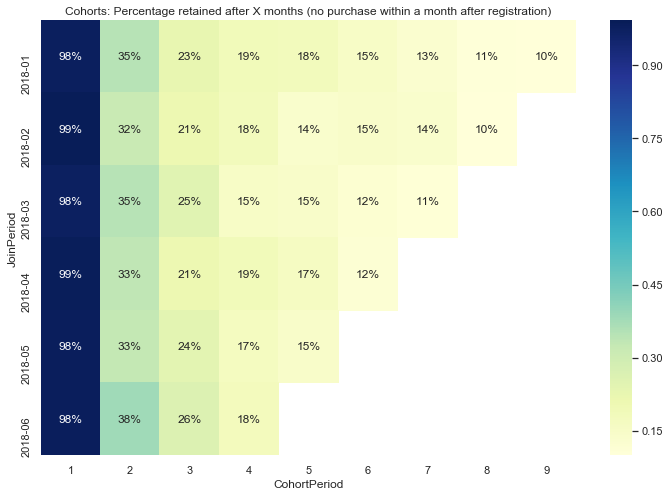

In [511]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Percentage retained after X months (no purchase within a month after registration)')
sns.heatmap(noWithin_retention.iloc[:,1:], mask=noWithin_retention.iloc[:,1:].isnull(), annot=True, fmt='.0%', cmap="YlGnBu", );
plt.savefig('nowithin.eps',format='eps')

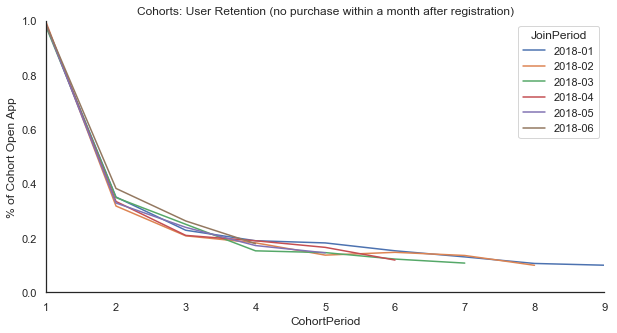

In [514]:
noWithin_retention.iloc[:,1:].T[['2018-01', '2018-02', '2018-03','2018-04','2018-05','2018-06']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention (no purchase within a month after registration)')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 9)
plt.ylim(0,1)
plt.ylabel('% of Cohort Open App')
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.savefig('折線圖條件無.eps',format='eps')
